# Import learning data

In [40]:
import pandas as pd

data_path = "../learning_data/data/win_rate/flop/100-data-100-simulation-2-players-win-rate-data.csv"
df = pd.read_csv(data_path)

# About learning data

In [41]:
df.shape

(100, 11)

In [42]:
df.head()

,hole1,hole2,community1,community2,community3,win_rate,hole1_id,hole2_id,community1_id,community2_id,community3_id
0,CK,CT,CA,D9,C9,0.74,13,10,1,22,9
1,DA,H2,C9,SJ,S4,0.45,14,28,9,50,43
2,D4,DT,D9,SJ,D2,0.62,17,23,22,50,15
3,C5,CT,DJ,C9,H7,0.53,5,10,24,9,33
4,D3,SJ,C8,C5,CK,0.47,16,50,8,5,13


In [43]:
df.describe()

,win_rate,hole1_id,hole2_id,community1_id,community2_id,community3_id
count,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000
mean,0.574600,26.860000,27.410000,21.180000,24.82000,24.670000
std,0.152987,15.946894,15.410278,14.113093,15.57282,16.413874
min,0.280000,1.000000,1.000000,1.000000,1.00000,1.000000
25%,0.460000,14.000000,13.750000,7.000000,11.00000,9.000000
50%,0.555000,26.000000,28.000000,22.000000,24.00000,23.500000
75%,0.660000,43.250000,41.000000,32.250000,38.00000,40.000000
max,0.990000,52.000000,52.000000,52.000000,51.00000,52.000000


# Data Processing

## card id -> 1-hot vector

In [44]:
import numpy as np

gen_one_hot = lambda target_ids: [1 if i in target_ids else 0 for i in range(1,53)]
fetch_hole = lambda row: [row[key] for key in ['hole1_id', 'hole2_id']]
fetch_community = lambda row: [row[key] for key in ['community1_id', 'community2_id', 'community3_id']]
hole_one_hot = df.apply(lambda row: gen_one_hot(fetch_hole(row)), axis=1)
community_one_hot = df.apply(lambda row: gen_one_hot(fetch_community(row)), axis=1)
df["onehot"] = hole_one_hot + community_one_hot

## Separate data for training and validation

In [45]:
validation_rate = 0.1
boundary_idx = int(df.shape[0]*(1-validation_rate))
train_df = df[:boundary_idx]
validation_df = df[boundary_idx:]

## Format data (pandas.df -> numpy.ndarray)

In [46]:
to_ndarray = lambda X: np.array([np.array(x) for x in X])
train_x, train_y = [to_ndarray(array) for array in [train_df["onehot"].values, train_df["win_rate"].values]]
val_x, val_y = [to_ndarray(array) for array in [validation_df["onehot"].values, validation_df["win_rate"].values]]
print "shape of training x: %s, y: %s" % (train_x.shape, train_y.shape)
print "shape of validation x: %s, y: %s" % (val_x.shape, val_y.shape)

shape of training x: (90, 104), y: (90,)
shape of validation x: (10, 104), y: (10,)


# Create model

In [47]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

model = Sequential()
model.add(Dense(60, input_dim=104))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss="mse",  optimizer="rmsprop")

# Train model

In [48]:
history = model.fit(train_x, train_y, batch_size=128, nb_epoch=100, validation_split=0.1, verbose=0)

# Check model performance

## Visualize loss transition

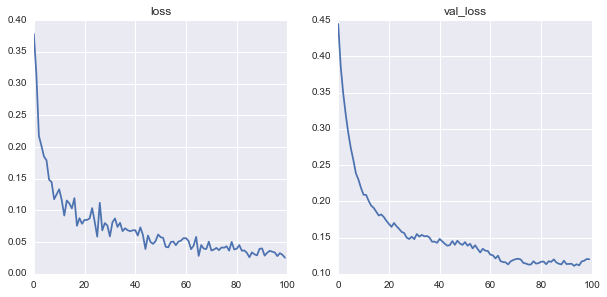

In [49]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for idx, key in enumerate(history.history, start=1):
    plt.subplot(2, 2, idx)
    plt.plot(range(len(history.history[key])), history.history[key])
    plt.title(key)
plt.show()

## Test model performance by MSE 

In [50]:
from sklearn.metrics import mean_squared_error

def print_model_performance(model, train_x, train_y, val_x, val_y):
    print 'MSE on training data = {score}'.format(score=mean_squared_error(model.predict(train_x), train_y))
    print 'MSE on validation data = {score}'.format(score=mean_squared_error(model.predict(val_x), val_y))

In [51]:
print_model_performance(model, train_x, train_y, val_x, val_y)

MSE on training data = 0.014726179729
MSE on validation data = 0.0726448249175


## See model prediction on sample data

In [56]:
from pypokerengine.engine.card import Card
C, D, H, S = Card.CLUB, Card.DIAMOND, Card.HEART, Card.SPADE

test_case = [
    [(4, C), (10, S), (10, D), (1, C), (10, H), 0.954],
    [(4, S), (2, S), (12, D), (11, C), (10, D), 0.274],
    [(1, H), (11, H), (8, D), (3, C), (7, D), 0.507]
]

gen_one_hot = lambda target_ids: [1 if i in target_ids else 0 for i in range(1,53)]
to_id = lambda card: card.to_id()

for card1, card2, card3, card4, card5, expected in test_case:
    cards = [Card(rank=rank, suit=suit) for rank, suit in [card1, card2, card3, card4, card5]]
    hole = cards[:2]
    community = cards[2:]
    hole_onehot = gen_one_hot(map(to_id, hole))
    community_onehot = gen_one_hot(map(to_id, community))
    x = hole_onehot + community_onehot
    X = np.array([x])
    y = model.predict(X)[0][0]
    print "HOLE = [%s, %s], COMMUNITY = [%s, %s, %s] => win_rate = { prediction=%f, expected=%f }" % tuple(map(str, hole) + map(str, community) + [y , expected])

HOLE = [C4, ST], COMMUNITY = [DT, CA, HT] => win_rate = { prediction=0.460148, expected=0.954000 }
HOLE = [S4, S2], COMMUNITY = [DQ, CJ, DT] => win_rate = { prediction=0.548395, expected=0.274000 }
HOLE = [HA, HJ], COMMUNITY = [D8, C3, D7] => win_rate = { prediction=0.353927, expected=0.507000 }
